# Anomoly Detection with Time Series Exercies

## Exercises
file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb
- The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint:** You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

- Label students by the program they are in.
- Is it possible to identify the user_id of a staff member?
- Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
- Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.
- Plot the access activity of these students.

**BONUS:** Identify users who are viewing both the web dev and data science curriculum

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
sql = '''
    SELECT logs.date,
    logs.user_id, 
    logs.path as endpoint, 
    logs.ip as source_ip,
    logs.cohort_id, 
    cohorts.name as cohort_name, 
    cohorts.start_date as cohort_start,
    cohorts.end_date as cohort_end, 
    cohorts.program_id
    FROM logs
    LEFT JOIN cohorts on cohorts.id=logs.cohort_id
    '''

In [3]:
import os
file = 'curriculum_logs.csv'
if os.path.isfile(file):
    df = pd.read_csv(file, index_col=0)
else:
    df = pd.read_sql(sql,url)
    df.to_csv(file)
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id
0,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0


In [4]:
df.shape

(900223, 9)

In [5]:
# check for dulicates
df.duplicated().sum()

347718

In [6]:
# look at duplicated rows
df[df.duplicated(keep=False)].head() #looks like entries are doubled, giong to keep first only

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id
4,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0
5,2018-01-26,2,javascript-i/loops,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0
7,2018-01-26,3,javascript-i/functions,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0
8,2018-01-26,2,javascript-i/loops,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0
9,2018-01-26,4,javascript-i/functions,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0


In [7]:
# removing duplicate rows and show shape
df = df.drop_duplicates(keep='first')
df.shape

(552505, 9)

In [8]:
# replace blanks with
df = df.replace('', np.nan)

In [9]:
# check for nulls
df.isna().sum()

date                0
user_id             0
endpoint            1
source_ip           0
cohort_id       32122
cohort_name     32122
cohort_start    32122
cohort_end      32122
program_id      32122
dtype: int64

In [10]:
# drop nulls for now
df = df.dropna()
df.shape

(520382, 9)

In [11]:
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id
0,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0


## 1) Label Students by Program

In [12]:
# how many program are there?
df.program_id.value_counts()

2.0    438674
3.0     63180
1.0     18524
4.0         4
Name: program_id, dtype: int64

In [13]:
# look at program 2 since it's the largest
list(df[df.program_id==2].cohort_name.unique())

['Teddy',
 'Sequoia',
 'Niagara',
 'Pinnacles',
 'Mammoth',
 'Ulysses',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda',
 'Betelgeuse',
 'Ceres',
 'Deimos',
 'Europa',
 'Fortuna',
 'Apex',
 'Ganymede',
 'Hyperion',
 'Bash',
 'Jupiter',
 'Kalypso',
 'Luna',
 'Marco',
 'Neptune',
 'Oberon']

In [14]:
# look at program 2 since it's the largest
list(df[df.program_id==3].cohort_name.unique()) # looks like data science students

['Bayes', 'Curie', 'Darden', 'Easley', 'Florence']

In [15]:
# look at program 2 since it's the largest
list(df[df.program_id==1].cohort_name.unique())

['Hampton',
 'Arches',
 'Quincy',
 'Kings',
 'Lassen',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Badlands',
 'Ike',
 'Franklin',
 'Everglades']

In [16]:
# look at program 2 since it's the largest
list(df[df.program_id==4].cohort_name.unique())

['Apollo']

In [18]:
# df subset by program_id, check paths to confirm its data science
df[df.program_id==3].endpoint.value_counts(normalize=True) # comfirms program_2 is data science

/                                             0.095014
search/search_index.json                      0.019864
classification/overview                       0.015923
sql/mysql-overview                            0.014229
classification/scale_features_or_not.svg      0.013659
                                                ...   
spring/extra-features/error-pages/asdfasdf    0.000016
12-distributed-ml/8.1-classification          0.000016
9-timeseries/6.2-prophet                      0.000016
split-and-scale                               0.000016
5-stats/4.2-compare-means/null                0.000016
Name: endpoint, Length: 682, dtype: float64

In [19]:
# df subset by program_id, check path info for instruction type
df[df.program_id==2].endpoint.value_counts(normalize=True) # seems to be java related to 'web dev'

/                                                 0.067285
javascript-i                                      0.024647
toc                                               0.024148
search/search_index.json                          0.019677
html-css                                          0.018207
                                                    ...   
11-distributed-ml/6.4-prepare-part-4              0.000002
spring/fundamentals/relationships/null            0.000002
4-stats/2.1-probability_and_event_interactions    0.000002
examples/twitter.html                             0.000002
extra-challenges/mysql/mysql-extra-exercises      0.000002
Name: endpoint, Length: 1913, dtype: float64

In [20]:
# df subset by program_id, check path for instruction type
df[df.program_id==1].endpoint.value_counts(normalize=True) # seems to be java, html, nlp, dataset, mix of things. maybe for staff

/                                           0.069639
index.html                                  0.028072
javascript-i                                0.021756
html-css                                    0.016573
appendix                                    0.015763
                                              ...   
appendix/postwork/sales-tax                 0.000054
4-python/6-imports                          0.000054
content/examples/git                        0.000054
content/conditionals.html                   0.000054
content/mysql/relationships/indexes.html    0.000054
Name: endpoint, Length: 710, dtype: float64

In [22]:
# investigate program_id 1 further
df[df.program_id==1].groupby('endpoint').date.count().sort_values(ascending=False).head(30) #mostly jaba so 'web dev'

endpoint
/                                                   1290
index.html                                           520
javascript-i                                         403
html-css                                             307
appendix                                             292
spring                                               289
javascript-ii                                        268
java-i                                               247
java-iii                                             246
java-ii                                              233
jquery                                               223
mysql                                                176
content/laravel/intro                                142
content/html-css                                     132
java-i/introduction-to-java                          116
javascript-i/conditionals                            110
javascript-i/loops                                   110
javascript-i/functions

In [23]:
# df subset by program_id, check paths to confirm its data science
df[df.program_id==4].endpoint.value_counts(normalize=True) # seemto be html so 'web dev'

content/html-css/gitbook/images/favicon.ico    0.25
content/html-css/introduction.html             0.25
/                                              0.25
content/html-css                               0.25
Name: endpoint, dtype: float64

### program 3 is data science
### all others are web dev

In [24]:
df['program_name'] = np.where(df.program_id==3,'data_science', 'web_dev')
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id,program_name
0,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
1,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
3,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
4,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0,web_dev


## 2) Is it possible to identify the user_id of a staff member?

In [26]:
df[df.cohort_name=='Staff'].groupby('user_id').count()

,date,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id,program_name
user_id,,,,,,,,,
1,3706,3706,3706,3706,3706,3706,3706,3706,3706
11,7066,7066,7066,7066,7066,7066,7066,7066,7066
37,237,237,237,237,237,237,237,237,237
40,45,45,45,45,45,45,45,45,45
41,151,151,151,151,151,151,151,151,151
53,2224,2224,2224,2224,2224,2224,2224,2224,2224
64,6029,6029,6029,6029,6029,6029,6029,6029,6029
146,860,860,860,860,860,860,860,860,860
148,20,20,20,20,20,20,20,20,20


## 3) Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [27]:
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id,program_name
0,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
1,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
3,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
4,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0,web_dev


In [28]:
df.date = pd.to_datetime(df.date)
df.dtypes

date            datetime64[ns]
user_id                  int64
endpoint                object
source_ip               object
cohort_id              float64
cohort_name             object
cohort_start            object
cohort_end              object
program_id             float64
program_name            object
dtype: object

In [30]:
df = df.set_index(df.date)
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id,program_name
date,,,,,,,,,,
2018-01-26,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0,web_dev


In [32]:
df[df.index > df.cohort_end].user_id.unique()

array([  1,  11,  21,  26,  37,  40,  50,  51,  53,  60,  64,  66,  67,
        68,  69,  70,  71,  72,  75,  76,  77,  80,  81,  82,  83,  84,
        85,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98, 101, 102,
        16,  42,  41,  17,  22,  15, 104,  47,  57,  10, 105, 106,  28,
       107,  65,  52,  33,  56, 108,  27,  38,  36, 109, 110, 112, 113,
       114, 115, 139, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151,
       152, 153, 156, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172,
       173, 174, 175, 177, 178, 179,  29,  19, 180,   6,  99,  43,  31,
         7, 181, 138,  35, 142,   5, 155, 154,  88, 209, 210,  18,   3,
        20, 118, 211, 212, 214, 216, 217, 131, 135, 128, 127, 124, 130,
       159,  12, 145, 241, 242, 136, 157, 171, 123,  25, 134, 119, 243,
       244, 245, 246, 160, 248, 252, 254, 255, 120, 257, 279, 280, 281,
        14, 253, 188, 186, 283, 184, 215, 278, 183, 204, 193, 195, 197,
       249, 206, 284, 121, 201, 285, 286, 311, 190, 312, 116, 20

## 4) Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

In [33]:
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    309
2018-01-27    152
2018-01-28    111
2018-01-29    453
2018-01-30    384
Freq: D, Name: endpoint, dtype: int64

In [34]:
pages.shape

(1182,)

<AxesSubplot:xlabel='date'>

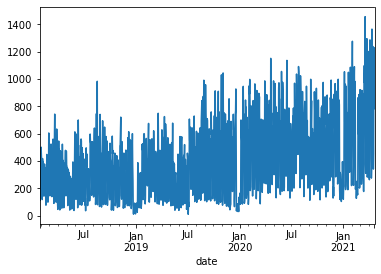

In [35]:
pages.plot()

In [36]:
ema_7d = pages.ewm(span=7)
ema_7d

ExponentialMovingWindow [com=3.0,min_periods=1,adjust=True,ignore_na=False,axis=0]

In [37]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d

date
2018-01-26    309.000000
2018-01-27    219.285714
2018-01-28    172.459459
2018-01-29    275.057143
2018-01-30    310.766965
                 ...    
2021-04-17    790.205528
2021-04-18    706.904146
2021-04-19    837.428109
2021-04-20    931.071082
2021-04-21    894.053312
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [38]:
# the first ema is the first value of df so confirm by making them ==
ema_7d[0] == pages[0]

True

In [39]:
# 14 day EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d

date
2018-01-26    309.000000
2018-01-27    224.892857
2018-01-28    181.385399
2018-01-29    264.479967
2018-01-30    295.662561
                 ...    
2021-04-17    809.813260
2021-04-18    762.771492
2021-04-19    824.935293
2021-04-20    876.543921
2021-04-21    864.071398
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [40]:
# 30 day EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d

date
2018-01-26    309.000000
2018-01-27    227.883333
2018-01-28    186.296927
2018-01-29    259.783343
2018-01-30    288.045640
                 ...    
2021-04-17    789.047232
2021-04-18    767.624830
2021-04-19    797.390970
2021-04-20    824.139940
2021-04-21    821.485750
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [41]:
# 90 day EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d

date
2018-01-26    309.000000
2018-01-27    229.627778
2018-01-28    189.203243
2018-01-29    257.366839
2018-01-30    283.831465
                 ...    
2021-04-17    703.267879
2021-04-18    697.855398
2021-04-19    709.528906
2021-04-20    720.572226
2021-04-21    721.944265
Freq: D, Name: endpoint, Length: 1182, dtype: float64

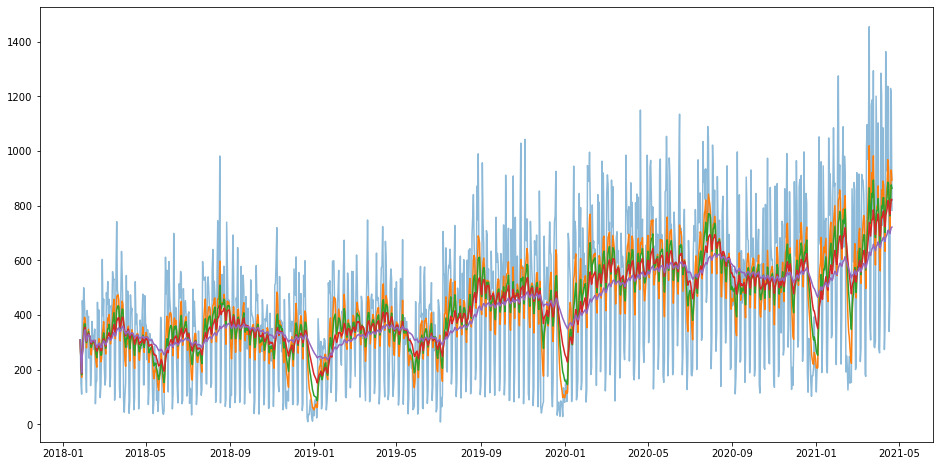

In [42]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label='7 day EMA')
ax.plot(pages.index, ema_14d, label='14 day EMA')
ax.plot(pages.index, ema_30d, label='30 day EMA')
ax.plot(pages.index, ema_90d, label='60 day EMA')

In [43]:
# create Bollinger Bandds midband

# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    309.000000
2018-01-27    227.883333
2018-01-28    186.296927
2018-01-29    259.783343
2018-01-30    288.045640
Freq: D, Name: endpoint, dtype: float64

In [44]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()
stdev.head()

date
2018-01-26           NaN
2018-01-27    111.015765
2018-01-28    103.251154
2018-01-29    160.731377
2018-01-30    148.706456
Freq: D, Name: endpoint, dtype: float64

In [45]:
# compute upper and lower bands with K=2
ub = midband + stdev*2
lb = midband - stdev*2
ub, lb

(date
 2018-01-26            NaN
 2018-01-27     449.914863
 2018-01-28     392.799235
 2018-01-29     581.246097
 2018-01-30     585.458551
                  ...     
 2021-04-17    1563.333259
 2021-04-18    1534.681134
 2021-04-19    1574.293189
 2021-04-20    1603.605811
 2021-04-21    1575.668655
 Freq: D, Name: endpoint, Length: 1182, dtype: float64,
 date
 2018-01-26          NaN
 2018-01-27     5.851804
 2018-01-28   -20.205381
 2018-01-29   -61.679412
 2018-01-30    -9.367271
                 ...    
 2021-04-17    14.761206
 2021-04-18     0.568526
 2021-04-19    20.488752
 2021-04-20    44.674068
 2021-04-21    67.302845
 Freq: D, Name: endpoint, Length: 1182, dtype: float64)

In [46]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.head()

,endpoint,endpoint
date,,
2018-01-26,NaN,NaN
2018-01-27,449.914863,5.851804
2018-01-28,392.799235,-20.205381
2018-01-29,581.246097,-61.679412
2018-01-30,585.458551,-9.367271


In [47]:
bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,449.914863,5.851804
2018-01-28,392.799235,-20.205381
2018-01-29,581.246097,-61.679412
2018-01-30,585.458551,-9.367271


In [48]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df 

,endpoint,endpoint,ub,lb
date,,,,
2018-01-26,309,309.000000,NaN,NaN
2018-01-27,152,227.883333,449.914863,5.851804
2018-01-28,111,186.296927,392.799235,-20.205381
2018-01-29,453,259.783343,581.246097,-61.679412
2018-01-30,384,288.045640,585.458551,-9.367271
...,...,...,...,...
2021-04-17,340,789.047232,1563.333259,14.761206
2021-04-18,457,767.624830,1534.681134,0.568526
2021-04-19,1229,797.390970,1574.293189,20.488752


In [49]:
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,309,309.000000,NaN,NaN
2018-01-27,152,227.883333,449.914863,5.851804
2018-01-28,111,186.296927,392.799235,-20.205381
2018-01-29,453,259.783343,581.246097,-61.679412
2018-01-30,384,288.045640,585.458551,-9.367271


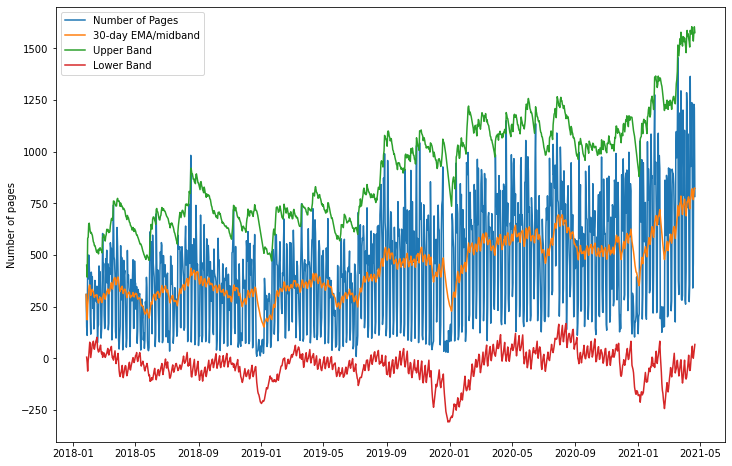

In [50]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [51]:
# create column %b for each pages values. No value for first observation
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,309,309.000000,NaN,NaN,NaN
2018-01-27,152,227.883333,449.914863,5.851804,0.329116
2018-01-28,111,186.296927,392.799235,-20.205381,0.317685
2018-01-29,453,259.783343,581.246097,-61.679412,0.800527
2018-01-30,384,288.045640,585.458551,-9.367271,0.661315


In [52]:
# find anomolies by filtering for %b above 1
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,604,294.983657,585.169732,4.797582,1.032445
2018-05-30,612,233.907085,578.989203,-111.175033,1.047830
2018-08-17,982,436.317898,919.829477,-47.193681,1.064291
2019-03-20,748,366.392228,737.537570,-4.753114,1.014095
2019-07-08,706,278.047868,687.487687,-131.391950,1.022607


In [53]:
# create df for one user
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id,program_name
date,,,,,,,,,,
2018-01-26,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0,web_dev


In [54]:
user = 1
span = 30

In [56]:
# create df for single user
df = df[df.user_id == user]
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id,program_name
date,,,,,,,,,,
2018-01-26,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev
2018-01-26,2018-01-26,1,javascript-i/functions,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0,web_dev


In [58]:
# resample df.path daily and count to find how many hits for path
pages_one_user = df['endpoint'].resample('d').count()
pages_one_user.head()

date
2018-01-26    7
2018-01-27    1
2018-01-28    0
2018-01-29    4
2018-01-30    5
Freq: D, Name: endpoint, dtype: int64

In [59]:
# Calculate upper and lower bollinger band and midband
weight = 2
midband = pages_one_user.ewm(span=span).mean()
stdev = pages_one_user.ewm(span=span).std()
ub = midband + stdev*weight
lb = midband - stdev*weight
ub, lb, midband

(date
 2018-01-26          NaN
 2018-01-27    12.385281
 2018-01-28     9.978877
 2018-01-29     9.108861
 2018-01-30     9.010169
                 ...    
 2021-04-17    15.760437
 2021-04-18    15.420042
 2021-04-19    15.174322
 2021-04-20    15.171240
 2021-04-21    15.476636
 Freq: D, Name: endpoint, Length: 1182, dtype: float64,
 date
 2018-01-26         NaN
 2018-01-27   -4.585281
 2018-01-28   -4.954072
 2018-01-29   -3.264280
 2018-01-30   -2.220131
                 ...   
 2021-04-17   -6.459287
 2021-04-18   -6.073805
 2021-04-19   -5.656874
 2021-04-20   -5.235563
 2021-04-21   -4.891648
 Freq: D, Name: endpoint, Length: 1182, dtype: float64,
 date
 2018-01-26    7.000000
 2018-01-27    3.900000
 2018-01-28    2.512403
 2018-01-29    2.922290
 2018-01-30    3.395019
                 ...   
 2021-04-17    4.650575
 2021-04-18    4.673119
 2021-04-19    4.758724
 2021-04-20    4.967839
 2021-04-21    5.292494
 Freq: D, Name: endpoint, Length: 1182, dtype: float64)

In [60]:
# Add upper and lower band values to dataframe
bb = pd.concat([ub, lb], axis=1)
bb.head()

,endpoint,endpoint
date,,
2018-01-26,NaN,NaN
2018-01-27,12.385281,-4.585281
2018-01-28,9.978877,-4.954072
2018-01-29,9.108861,-3.264280
2018-01-30,9.010169,-2.220131


In [61]:
# Combine all data into a single dataframe
my_df = pd.concat([pages_one_user, midband, bb], axis=1)
my_df.head()

,endpoint,endpoint,endpoint,endpoint
date,,,,
2018-01-26,7,7.000000,NaN,NaN
2018-01-27,1,3.900000,12.385281,-4.585281
2018-01-28,0,2.512403,9.978877,-4.954072
2018-01-29,4,2.922290,9.108861,-3.264280
2018-01-30,5,3.395019,9.010169,-2.220131


In [62]:
my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
my_df.head()

,pages_one_user,midband,ub,lb
date,,,,
2018-01-26,7,7.000000,NaN,NaN
2018-01-27,1,3.900000,12.385281,-4.585281
2018-01-28,0,2.512403,9.978877,-4.954072
2018-01-29,4,2.922290,9.108861,-3.264280
2018-01-30,5,3.395019,9.010169,-2.220131


In [63]:
# Calculate percent b and relevant user id to dataframe
my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
my_df.head()

,pages_one_user,midband,ub,lb,pct_b
date,,,,,
2018-01-26,7,7.000000,NaN,NaN,NaN
2018-01-27,1,3.900000,12.385281,-4.585281,0.329116
2018-01-28,0,2.512403,9.978877,-4.954072,0.331754
2018-01-29,4,2.922290,9.108861,-3.264280,0.587101
2018-01-30,5,3.395019,9.010169,-2.220131,0.642915


In [64]:
my_df['user_id'] = user
my_df.head()

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-01-26,7,7.000000,NaN,NaN,NaN,1
2018-01-27,1,3.900000,12.385281,-4.585281,0.329116,1
2018-01-28,0,2.512403,9.978877,-4.954072,0.331754,1
2018-01-29,4,2.922290,9.108861,-3.264280,0.587101,1
2018-01-30,5,3.395019,9.010169,-2.220131,0.642915,1


In [65]:
my_df[my_df.pct_b>1]

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,19,3.336015,14.348850,-7.676821,1.211170,1
2018-04-03,18,5.456616,17.629332,-6.716099,1.015225,1
2018-04-16,19,4.700875,16.948054,-7.546303,1.083772,1
2018-05-22,15,4.116934,14.169685,-5.935817,1.041298,1
2018-05-29,38,5.811539,25.347528,-13.724449,1.323825,1
2018-07-20,15,3.912445,14.236656,-6.411765,1.036969,1
2018-07-31,18,4.332966,15.590073,-6.924140,1.107040,1
2018-08-07,29,5.951888,21.812643,-9.908867,1.226577,1
2018-11-07,6,0.700372,4.272144,-2.871400,1.241877,1


## Makes Functions

In [66]:
def acquire_logs(user=env.user, password=env.password, host=env.host):
    '''
    This function uses env creditial to pull tables cohort and logs from database curriculum_logs.
    It read from a csv file if it exist or pull from the server and then write to a csv vile.
    '''
    
    # read from file if it exist 
    import os
    file = 'curriculum_logs.csv'
    if os.path.isfile(file):
        df = pd.read_csv(file, index_col=0)
    # or read from sql server and write to csv file
    else:
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        sql = '''
        SELECT logs.date,
        logs.user_id, 
        logs.path as endpoint, 
        logs.ip as source_ip,
        logs.cohort_id, 
        cohorts.name as cohort_name, 
        cohorts.start_date as cohort_start,
        cohorts.end_date as cohort_end, 
        cohorts.program_id
        FROM logs
        LEFT JOIN cohorts on cohorts.id=logs.cohort_id
        '''
        
        # read from sql server and create dataframe
        df = pd.read_sql(sql,url)
        
#         # add column that names program_id == 3 as 'data_science' and others as 'web_dev'
#         df['program_name'] = np.where(df.program_id == '3', 'data_science', 'web_dev')
        
#         # add column that identified logs observations that were created after cohort grad date
#         df['accessed_after_grad'] = np.where(df.index > df.cohort_end, 'yes', 'no')        

        # write df to csv file
        df.to_csv(file)
    return df

def one_user_df_prep(df, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

In [67]:
df = acquire_logs()
df.head()

,date,user_id,endpoint,source_ip,cohort_id,cohort_name,cohort_start,cohort_end,program_id
0,2018-01-26,1,/,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26,1,java-ii,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26,1,java-ii/object-oriented-programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26,1,slides/object_oriented_programming,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,1.0
4,2018-01-26,2,javascript-i/conditionals,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2.0


In [73]:
user = 1
span = 30
weight = 2
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [74]:
anomalies.head()

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2018-02-20,54,6.456745,35.718248,-22.804758,1.312386,1
2018-03-19,35,9.304089,32.368632,-13.760453,1.057044,1
2018-05-04,27,7.179313,24.736171,-10.377545,1.064471,1
2018-05-11,27,8.141119,26.687629,-10.405390,1.008421,1
2018-05-29,68,9.612443,44.787234,-25.562347,1.329963,1


In [75]:
span = 30
weight = 2

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [76]:
anomalies.sort_values(by='pct_b', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-06-23,59,3.806452,33.291099,-25.678196,1.435971,134
2021-02-20,19,1.225806,10.720862,-8.269249,1.435971,266
2021-02-28,8,0.516129,4.514047,-3.481789,1.435971,459
2021-03-28,15,0.967742,8.463839,-6.528355,1.435971,13
2020-05-08,3,0.193548,1.692768,-1.305671,1.435971,121
...,...,...,...,...,...,...
2018-11-12,16,5.696792,15.996388,-4.602803,1.000175,271
2020-07-23,19,5.781676,18.995809,-7.432458,1.000159,625
2020-10-13,30,8.716060,29.996078,-12.563959,1.000092,757


In [77]:
anomalies.sort_values(by='pages_one_user', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-07-22,285,44.915959,192.499064,-102.667146,1.313386,11
2019-03-03,272,24.721632,163.040772,-113.597508,1.393869,341
2020-04-16,271,44.194413,193.288101,-104.899276,1.260614,570
2019-07-25,253,34.698961,160.039466,-90.641543,1.370832,422
2020-04-26,234,54.999406,211.467475,-101.468663,1.072004,570
...,...,...,...,...,...,...
2020-09-25,1,0.064516,0.564257,-0.435225,1.435969,406
2018-05-04,1,0.083575,0.654077,-0.486926,1.303175,84
2020-07-09,1,0.066557,0.670070,-0.536955,1.273342,358


In [78]:
anomalies.user_id.value_counts()

64     51
53     49
1      46
11     45
186    44
       ..
378     1
543     1
402     1
610     1
951     1
Name: user_id, Length: 825, dtype: int64

## 5) Plot the access activity of these students.

<AxesSubplot:xlabel='date'>

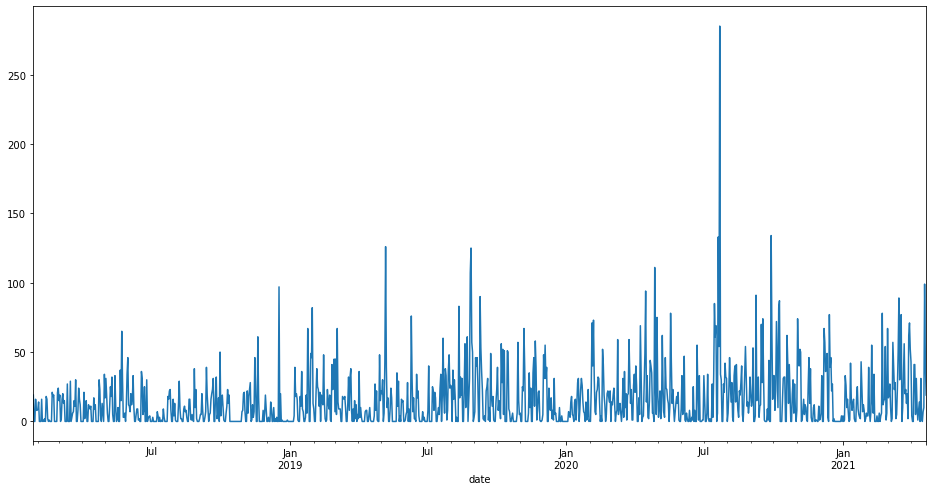

In [81]:
# plot by page_one_user count
df_11 = one_user_df_prep(df, 11)
df_11.plot(figsize=(16,8))

<AxesSubplot:xlabel='date'>

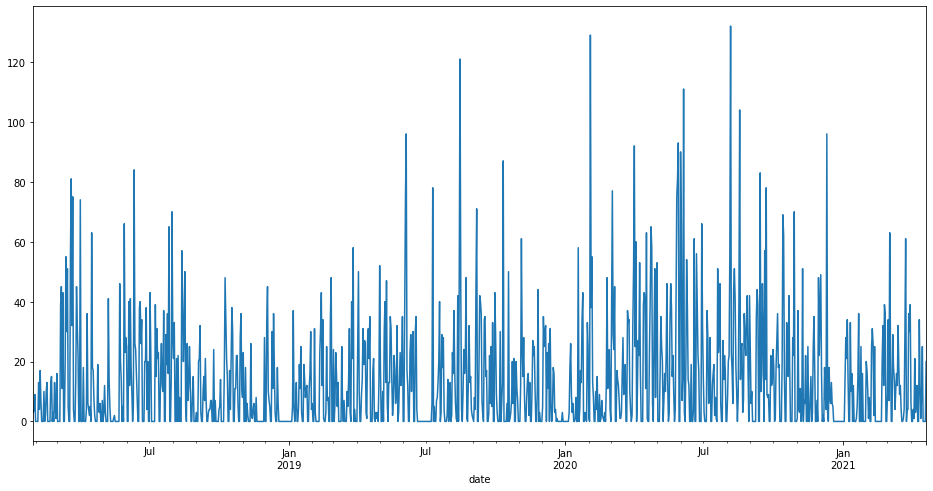

In [82]:
# plot by user_id count 
df_64 = one_user_df_prep(df, 64)
df_64.plot(figsize=(16,8))

## **BONUS:** Identify users who are viewing both the web dev and data science curriculum 